## This notebook is for Custom implementation of Facial Keypoints Detection using Pytorch from Scratch, using VGG16 model. 

In [77]:
!pip install torch_summary

In [148]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# downloading the data 

!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [10]:
data.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0


In [11]:
data.shape

(3462, 137)

In [20]:
doc = data.iloc[0]

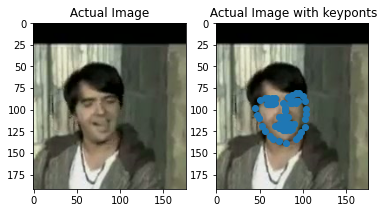

In [39]:
# before getting into actual work, printing the sample of expected result. 

img_arr = cv2.imread(os.path.join(root_dir, 'Luis_Fonsi_21.jpg'))
img_arr = img_arr[:,:,::-1]                                                       # converting BGR to RGB
x_points = data.iloc[0][1:][::2]
y_points = data.iloc[0][2:][::2]
plt.subplot(121)
plt.imshow(img_arr)
plt.title(" Actual Image ")
plt.subplot(122)
plt.imshow(img_arr)
plt.scatter(list(x_points), list(y_points))
plt.title(" Actual Image with keyponts")
plt.show()

### in this dataset, first column correpond to image name. Starting from second column, even columns correspond to X-axis of the facial points and odd columns correpsond to y-axis of the points

### total 68 facial points to be detected for each image 

In [140]:
# preparing the dataset and datalaoder 

class FaceDataset(Dataset):
  def __init__(self, df):
    super().__init__()
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    self.df = df

  def __getitem__(self, ix):
    doc = self.df.iloc[ix]
    image_name = doc[0]
    image_path = os.path.join(root_dir,image_name)  
    img_arr = cv2.imread(image_path)
    x_axis_points = doc[1:][::2]
    y_axis_points = doc[2:][::2]
    x_axis_points = list(x_axis_points/img_arr.shape[1])                                    # scaling the facial points with respective image_dim 
    y_axis_points = list(y_axis_points/img_arr.shape[0])                                    # so that we can use relative positions w.r.t image
    
    points = x_axis_points + y_axis_points  

    img_arr = img_arr/255.0                                                                 # scaling the image 
    img = self.preprocess_img(img_arr)
    
    return img.to(device), torch.tensor(points).to(device)

  def __len__(self):
    return self.df.shape[0]

    
  def preprocess_img(self, img):
    img = cv2.resize(img, (224,224)) 
    img = torch.tensor(img).permute(2,0,1) 
    img = self.normalize(img).float()
    return img
     
  def load_img(self, ix):
    doc = self.df.iloc[ix]
    img_name = doc[0]
    img = cv2.imread(os.path.join(root_dir, img_name))
    return img


In [127]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [128]:
print(train_df.shape)
print(test_df.shape)

(2769, 137)
(693, 137)


In [141]:
train_dataset = FaceDataset(train_df)
test_dataset = FaceDataset(test_df)

In [142]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -0.5194, -0.5331, -0.5319],
          [-2.1179, -2.1179, -2.1179,  ..., -0.5757, -0.5922, -0.5921],
          [-2.1179, -2.1179, -2.1179,  ..., -0.6423, -0.6525, -0.6525],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2145,  2.2113,  2.2243],
          [ 2.2488,  2.2487,  2.2489,  ...,  2.2315,  2.2147,  2.2284],
          [ 2.2362,  2.2419,  2.2489,  ...,  2.2317,  2.2215,  2.2284]],
 
         [[-1.7206, -1.7206, -1.7206,  ..., -0.0514, -0.0654, -0.0642],
          [-1.7206, -1.7206, -1.7206,  ..., -0.1090, -0.1258, -0.1257],
          [-1.7206, -1.7206, -1.7206,  ..., -0.1664, -0.1768, -0.1768],
          ...,
          [ 2.2765,  2.2566,  2.2294,  ...,  2.3062,  2.3238,  2.3427],
          [ 2.2630,  2.2254,  2.2185,  ...,  2.2716,  2.3060,  2.3201],
          [ 2.2230,  2.2185,  2.2185,  ...,  2.2712,  2.2920,  2.3201]],
 
         [[ 0.3393,  0.3393,  0.3393,  ...,  2.1231,  2.1092,  2.1104],
          [ 0.3393,  0.3393,

In [143]:
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)

In [144]:
for img, points in train_dataloader:
  print(img.shape)
  print(points.shape)
  break


torch.Size([25, 3, 224, 224])
torch.Size([25, 136])


In [67]:
# not that data pipeline is ready, creating model and training pipeline 

## getting VGG16 pretrained model from Pytorch

In [108]:
model = models.vgg16(pretrained=True)

In [122]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [110]:
# making the weights non trainable

for param in model.parameters():
  param.requires_grad = False

### next we will modify the model based on our requirement, since we need to predict 136 datapoints and each in the range of 0-1 values, we will remove the last 2 sections of model i.e, avgpool and classifier and add custom layers for training 

In [151]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer

final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(300, 136),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [152]:
model = model.to(device)

In [153]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [154]:
summary(model, torch.rand(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

## model has 3.5M parametes 

In [156]:
# getting the optimizer and loss_function 

def get_essentials():
  loss_fun = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  return loss_fun, optimizer

In [157]:
# defining batch_train and accuracy functions


def train_batch(data, model, loss_fun, optimizer):
  model.train()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  loss_val.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss_val.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
  model.eval()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  return loss_val.item()



In [158]:
epochs = 50
loss_fun, optimizer = get_essentials()


In [159]:
# training and validation loops 


train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
  train_batch_losses, val_batch_losses = [], []
  for data in train_dataloader:
    train_batch_loss = train_batch(data, model, loss_fun, optimizer)
    train_batch_losses.append(train_batch_loss)
  for data in test_dataloader:
    val_batch_loss = val_batch(data, model, loss_fun, optimizer)
    val_batch_losses.append(val_batch_loss)
  train_epoch.append(np.mean(train_batch_losses))
  val_epoch.append(np.mean(val_batch_losses))
  


100%|██████████| 50/50 [22:20<00:00, 26.81s/it]


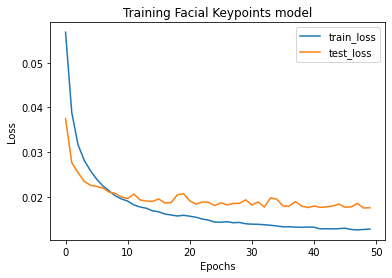

In [160]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

### model has trained 

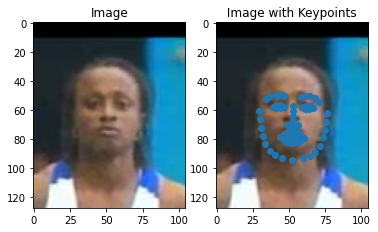

In [170]:
# Displaying the results

index = 8
test_img, points = test_dataset[index]
Facial_key_points = model(test_img[None]).flatten().detach().cpu()
plt.subplot(121)
plt.title("Image")
img = test_dataset.load_img(index)
img = img[:,:,::-1]                                                              
plt.imshow(img)
plt.subplot(122)
plt.title(" Image with Keypoints ")
plt.imshow(img)
plt.scatter(Facial_key_points[:68]*img.shape[1], Facial_key_points[68:]*img.shape[0])                          # scaling the keypoints with image dimension
plt.show()

## models performance is very good 